Brain Tumor Classification

https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

1. Load dependencies

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.cuda as cuda
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from torchsummary import summary 
from google.colab.patches import cv2_imshow
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models

import tensorflow as tf
import keras 
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn import decomposition, manifold, preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import copy
import random
import time
import cv2
import os
import math
import pathlib
from tqdm import tqdm
import os
import shutil
import itertools
import imutils
from timeit import default_timer as timer
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

In [2]:
use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")

2. Set Seed

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

3. Load Data

In [4]:
!git clone https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet.git

Cloning into 'Brain-Tumor-Classification-DataSet'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 27.44 MiB/s, done.


In [5]:
data_dir = 'Brain-Tumor-Classification-DataSet'
train_dir = data_dir+'/Training/'
test_dir = data_dir+'/Testing/'
labels = ['no_tumor','glioma_tumor','meningioma_tumor','pituitary_tumor']
save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

In [6]:
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

#If you use multiple gpus it turns statement multi_gpu = True. 
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

Train on gpu: True
1 gpus detected.


In [7]:
# Load data as np arrays
x_train = []
y_train = []
x_test = []
y_test = []
im_size = 224

for i in os.listdir(train_dir):
    for j in os.listdir(train_dir+i):
        x_train.append(cv2.resize(cv2.imread(train_dir+i+'/'+j),(im_size,im_size)))
        y_train.append(labels.index(i))
for i in os.listdir(test_dir):
    for j in os.listdir(test_dir+i):
        x_test.append(cv2.resize(cv2.imread(test_dir+i+'/'+j),(im_size,im_size)))
        y_test.append(labels.index(i))

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [8]:
#Verify the size of the datasets
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2870, 224, 224, 3)
(2870,)
(394, 224, 224, 3)
(394,)


Validation Set

In [9]:
# Create a validation set (10% of the training set)
VALID_RATIO = 0.9
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, shuffle=True)

In [10]:
x_valid = copy.deepcopy(x_valid)
y_valid = copy.deepcopy(y_valid)

In [11]:
#Verify the size of the validation set
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(2152, 224, 224, 3)
(2152,)
(718, 224, 224, 3)
(718,)


Data Visualization

In [12]:
#Look at the class distribution
y = dict()
y[0] = []
y[1] = []
y[2] = []
y[3] = []
for set_name in (y_train, y_valid, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))
    y[2].append(np.sum(set_name == 2))
    y[3].append(np.sum(set_name == 3))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='no_tumor',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='glioma_tumor',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
trace2 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[2],
    name='meningioma_tumor',
    marker=dict(color='#EEC900'),
    opacity=0.7
)
trace3 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[3],
    name='pituitary_tumor',
    marker=dict(color='#66CDAA'),
    opacity=0.7
)
data = [trace0, trace1,trace2,trace3]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [13]:
#Plot some images from each class to visualize the data
def plot_samples(x, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = x[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

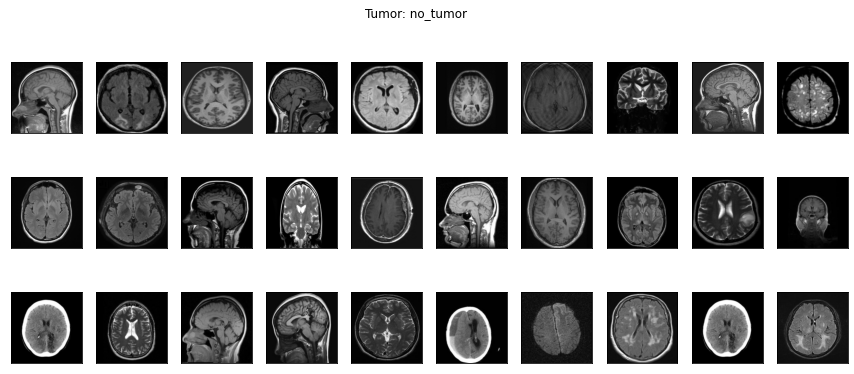

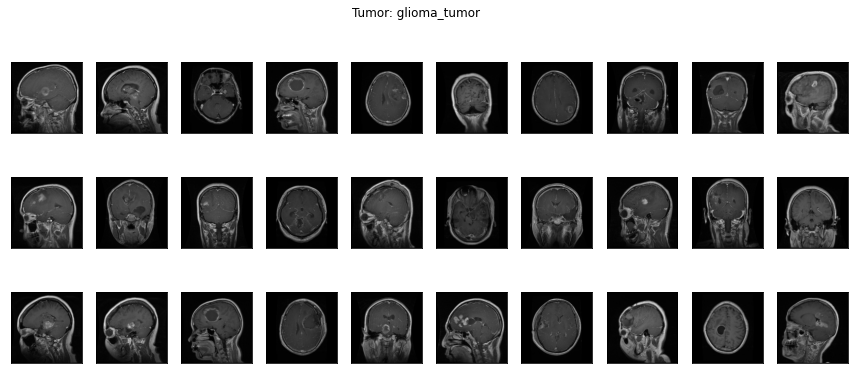

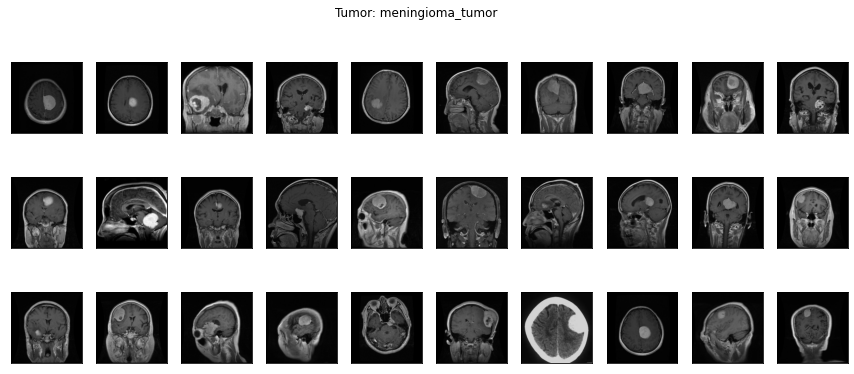

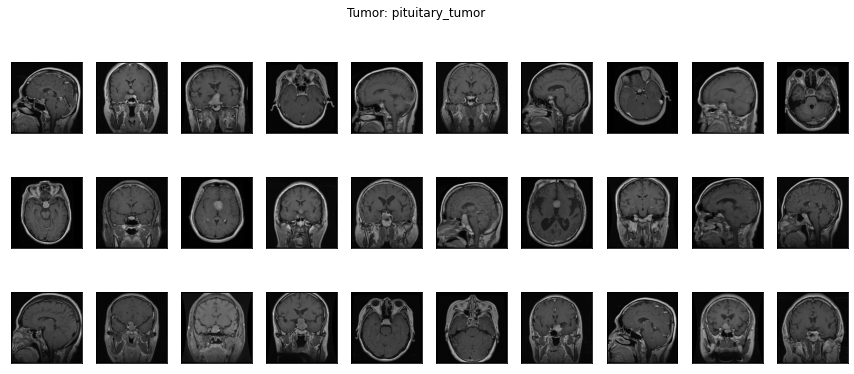

In [14]:
plot_samples(x_train, y_train, labels, 30)

Pre-processing for segmentation

In [15]:
#Crop the images at the borders of the imaged brain
IMG_SIZE=(150,150)
img = cv2.imread(train_dir+'meningioma_tumor/m (22).jpg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
#Convert to grayscale and add gaussian blur to improve thresholding
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
thresh = cv2.erode(thresh, None, iterations=1)
thresh = cv2.dilate(thresh, None, iterations=2)
#Find the contours/borders
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

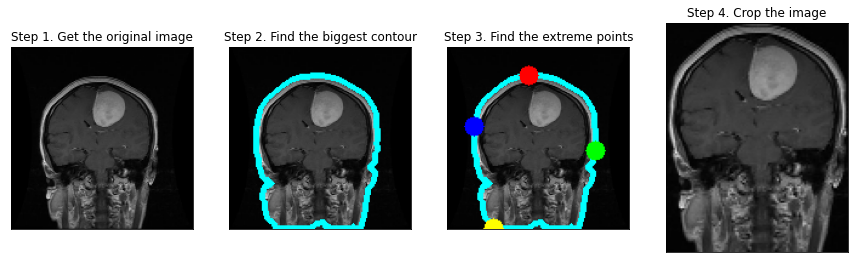

In [16]:
#Plot the cropped image
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

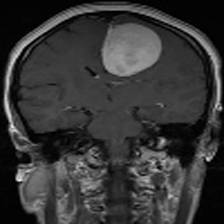

(224, 224, 3)


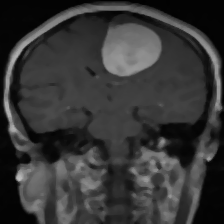

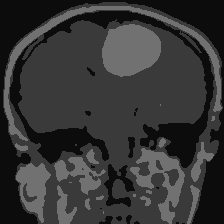

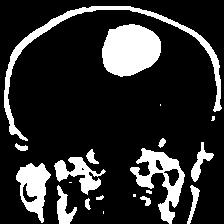

In [17]:
IMG_SIZE=(224,224)

#img = cv2.imread(train_dir+'meningioma_tumor/m (22).jpg')
img = cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB)

kernel = np.ones((5,5),np.uint8)
img = cv2.resize(
             img,
             dsize=IMG_SIZE,
             interpolation=cv2.INTER_CUBIC
         )
cv2_imshow(img)
print(img.shape)
#Add a median filter
img = cv2.medianBlur(img,5)
cv2_imshow(img)
#K means clustering
pixel_vals = img.reshape((-1,3))
pixel_vals = np.float32(pixel_vals)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
#k=3 for 3 clusters
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
segmented_img = segmented_data.reshape((img.shape))
cv2_imshow(segmented_img) #show segmented image
thresh = cv2.threshold(segmented_data, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
cv2_imshow(thresh.reshape(img.shape))

In [18]:
# Create a function to use for the whole dataset
IMG_SIZE=(224,224)
def cluster(set_name):
    set_new = []
    for img in set_name:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        kernel = np.ones((5,5),np.uint8)
        img = cv2.resize(
                    img,
                    dsize=IMG_SIZE,
                    interpolation=cv2.INTER_CUBIC
                )
        
        img = cv2.medianBlur(img,5)
        
        pixel_vals = img.reshape((-1,3))
        pixel_vals = np.float32(pixel_vals)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)
        k = 3
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
        centers = np.uint8(centers)
        segmented_data = centers[labels.flatten()]
        segmented_img = segmented_data.reshape((img.shape))
        set_new.append(segmented_img)
    return np.array(set_new)

In [19]:
#Apply pre-processing to the entire dataset
x_train_crop = cluster(set_name=x_train)
x_valid_crop = cluster(set_name=x_valid)
x_test_crop = cluster(set_name=x_test)

Save new images to folder

In [20]:

def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'no_tumor/'+str(i)+'.jpg', img)
        elif imclass == 1:
            cv2.imwrite(folder_name+'glioma_tumor/'+str(i)+'.jpg', img)
        elif imclass == 2:
            cv2.imwrite(folder_name+'meningioma_tumor/'+str(i)+'.jpg', img)
        elif imclass == 3:
            cv2.imwrite(folder_name+'pituitary_tumor/'+str(i)+'.jpg', img)
        i += 1

In [21]:
!mkdir TRAIN_CROP TEST_CROP VALID_CROP TRAIN_CROP/no_tumor TRAIN_CROP/glioma_tumor TRAIN_CROP/meningioma_tumor TRAIN_CROP/pituitary_tumor TEST_CROP/no_tumor TEST_CROP/glioma_tumor TEST_CROP/meningioma_tumor TEST_CROP/pituitary_tumor VALID_CROP/no_tumor VALID_CROP/glioma_tumor VALID_CROP/meningioma_tumor VALID_CROP/pituitary_tumor

save_new_images(x_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(x_valid_crop, y_valid, folder_name='VALID_CROP/')
save_new_images(x_test_crop, y_test, folder_name='TEST_CROP/')

Train = 'TRAIN_CROP/'
Valid = 'VALID_CROP/'
Test = 'TEST_CROP/'